In [11]:
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

In [12]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

In [60]:
!pip install duckduckgo_search
!pip install fastcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 10.0 MB/s eta 0:00:00


In [63]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [64]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=10):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')
    
urls = search_images('license plate photos', max_images=1)
urls[0]

Searching for 'license plate photos'


HTTPStatusError: Client error '403 Forbidden' for url 'https://duckduckgo.com/i.js?l=wt-wt&o=json&s=0&q=license%20plate%20photos&vqd=4-190265105160834603329344882235357485956&f=%2C%2C%2C%2C%2C&p=1'
For more information check: https://httpstatuses.com/403

In [78]:
!pip install google-search

In [83]:
from googlesearch import search

def search_images_google(term, max_images=10):
    print(f"Searching for '{term}'")

    # Use Google search to get image URLs
    urls = []
    for url in search_images(term, stop=max_images):
        urls.append(url)

    return urls

# Search for 'license plate photos' and retrieve URLs of images
image_urls = search_images_google('license plate photos', max_images=1)

# Print the first image URL
print(image_urls[0])

Searching for 'license plate photos'


TypeError: search_images() got an unexpected keyword argument 'stop'

In [29]:
!aws s3 cp --recursive ./plates/ s3://$bucket/content-moderation/media/

upload: plates/plates_1.png to s3://sagemaker-us-east-1-211125778552/content-moderation/media/plates_1.png


In [30]:
rekognition = boto3.client("rekognition")
s3 = boto3.client("s3")

/home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [42]:
!mkdir -p ./tmp
temp_folder = "tmp/"

In [32]:
imageName = "content-moderation/media/plates_1.png"

In [33]:
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": imageName})))

In [48]:
detectTextResponse = rekognition.detect_text(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": imageName,
        }
    },
)


In [49]:
display(detectTextResponse)

{'TextDetections': [{'DetectedText': 'ALABAMA',
   'Type': 'LINE',
   'Id': 0,
   'Confidence': 98.8377685546875,
   'Geometry': {'BoundingBox': {'Width': 0.1005859375,
     'Height': 0.020265767350792885,
     'Left': 0.0498046875,
     'Top': 0.0048251827247440815},
    'Polygon': [{'X': 0.0498046875, 'Y': 0.0048251827247440815},
     {'X': 0.150390625, 'Y': 0.0048251827247440815},
     {'X': 0.150390625, 'Y': 0.02509094960987568},
     {'X': 0.0498046875, 'Y': 0.02509094960987568}]}},
  {'DetectedText': 'ALASKA',
   'Type': 'LINE',
   'Id': 1,
   'Confidence': 98.75508880615234,
   'Geometry': {'BoundingBox': {'Width': 0.1005859375,
     'Height': 0.01640562154352665,
     'Left': 0.25,
     'Top': 0.006755255628377199},
    'Polygon': [{'X': 0.25, 'Y': 0.006755255628377199},
     {'X': 0.3505859375, 'Y': 0.006755255628377199},
     {'X': 0.3505859375, 'Y': 0.02316087670624256},
     {'X': 0.25, 'Y': 0.02316087670624256}]}},
  {'DetectedText': 'SEP',
   'Type': 'LINE',
   'Id': 2,
 

In [53]:
import string

for textDetection in detectTextResponse["TextDetections"]:
    # strip punctuation before checking match
    text = textDetection["DetectedText"].translate(str.maketrans("", "", string.punctuation))
    print("Detected word: {}".format(textDetection["DetectedText"]))

Detected word: ALABAMA
Detected word: ALASKA
Detected word: SEP
Detected word: ARIZONA
Detected word: 8
Detected word: Arkansas 09
Detected word: California
Detected word: DISABLED
Detected word: VETERAN
Detected word: BDC4544
Detected word: V94769
Detected word: 96
Detected word: GRAND CANYON STATE
Detected word: 946 КХН
Detected word: IUAM80I
Detected word: THE LAST GREAT RACE
Detected word: 04
Detected word: The Natural State
Detected word: YOSEMITE NATIONAL PARK
Detected word: 2001
Detected word: OCT23
Detected word: FLORIDA
Detected word: 05-03
Detected word: Connecticut
Detected word: 19
Detected word: Georgia
Detected word: 95
Detected word: DE LAWARE
Detected word: 955-LVM
Detected word: 167.XVS
Detected word: E145659
Detected word: DS5SD
Detected word: 9BW96
Detected word: COLORADO
Detected word: 06
Detected word: Constitution State
Detected word: Protect Wild Dolphins
Detected word: Centennial Olympic Games
Detected word: HAWAII
Detected word: LLINOIS 9.
Detected word: INDIAN

In [54]:
def drawBoundingBoxes(sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255, 255, 255), (255, 255, 255), (76, 182, 252), (52, 194, 123))

    # Download image locally
    imageLocation = temp_folder + os.path.basename(sourceImage)
    s3.download_file(bucket, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line = 3
    for box in boxes:
        x1 = int(box[1]["Left"] * width)
        y1 = int(box[1]["Top"] * height)
        x2 = int(box[1]["Left"] * width + box[1]["Width"] * width)
        y2 = int(box[1]["Top"] * height + box[1]["Height"] * height)

        draw.text((x1, y1), box[0], colors[col])
        for l in range(line):
            draw.rectangle((x1 - l, y1 - l, x2 + l, y2 + l), outline=colors[col])
        col = (col + 1) % maxcol

    imageFormat = "PNG"
    ext = sourceImage.lower()
    if ext.endswith("jpg") or ext.endswith("jpeg"):
        imageFormat = "JPEG"

    bbImage.save(imageLocation, format=imageFormat)

    display(bbImage)

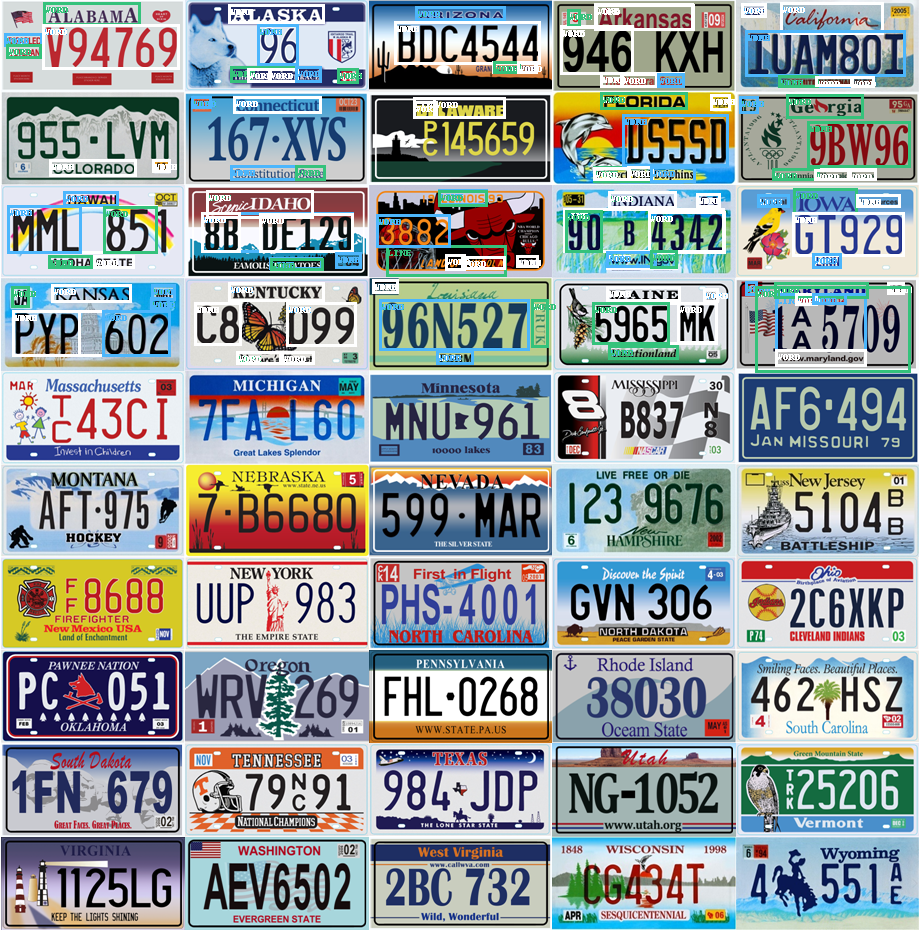

In [43]:
boxes = []
textDetections = detectTextResponse["TextDetections"]
for textDetection in textDetections:
    boxes.append((textDetection["Type"], textDetection["Geometry"]["BoundingBox"]))

drawBoundingBoxes(imageName, boxes)

In [1]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [2]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>